## Install Libraries And Set Required Parameters

The code here is created with the help of example provided
https://github.com/webis-de/small-text/blob/main/examples/notebooks/02-active-learning-with-stopping-criteria.ipynb

In [ ]:
%pip install small-text[transformers]==1.0.0b4
%pip install small_text==1.0.0b3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached small_text-1.0.0b3-py3-none-any.whl (122 kB)
  Attempting uninstall: small-text
    Found existing installation: small-text 1.0.0b4
    Uninstalling small-text-1.0.0b4:
      Successfully uninstalled small-text-1.0.0b4


In [ ]:
#!cp /content/drive/MyDrive/Colab\ Notebooks/DFUtilities.py DFUtilities.py

In [38]:
import pandas as pd
import numpy as np
from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import warnings
from tqdm import tqdm 
import DFUtilities
import torch
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score
from cf_matrix import make_confusion_matrix #(#Reference : https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py)
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
#Libraries from small_text ( https://small-text.readthedocs.io/en/latest/ )

from small_text.integrations.transformers.datasets import TransformersDataset
from small_text.active_learner import PoolBasedActiveLearner
from small_text.initialization import random_initialization_balanced
from small_text.integrations.transformers import TransformerModelArguments
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.query_strategies import PredictionEntropy
from small_text.query_strategies import RandomSampling
from small_text.integrations.transformers import TransformerModelArguments
from small_text.stopping_criteria import KappaAverage

In [ ]:
pd.set_option('display.width',None)
pd.set_option('display.max_colwidth',None)
warnings.filterwarnings("ignore")
tqdm.pandas()
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

In [ ]:
seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

## Load Data

In [ ]:
#As this is active our train dataset is the one where labels are already provided
train_path = "/content/ManualAnnotatedData.csv"
test_path = "/content/DataToBeLabeled.csv"

In [ ]:
dfHandler = DFUtilities.dfUtil()
df_train, df_unlabeled, log = dfHandler.handle_data(train_path,test_path) 

In [ ]:
log

['Length of Train Dataset : 3200',
 'Length of Test Dataset : 60123',
 'Number of Null Values in Train Dataset : 0',
 'Number of Null Values in Test Dataset : 0']

In [ ]:
df_train = df_train[['CleanText','Label']]
df_unlabeled = df_unlabeled['CleanText']

In [ ]:
#Split data to train and validate/test sets
df_train = df_train.sample(frac=1)
train_cleantext = df_train["CleanText"][:1000].to_list()
train_label = df_train["Label"][:1000].astype(int).to_list()

test_cleantext = df_train["CleanText"][1000:].to_list()
test_label = df_train["Label"][1000:].astype(int).to_list()

print(len(train_cleantext),len(test_cleantext))

1000 2200


## Define Active Learner

### Tokenization 
We need to convert words to numbers ( Word Representations )

In [ ]:
transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def get_transformers_dataset(tokenizer, data, labels, max_length=60):

    data_out = []

    for i, doc in enumerate(data):
        encoded_dict = tokenizer.encode_plus(
            doc,
            add_special_tokens=True,
            padding='max_length',
            max_length=max_length,
            return_attention_mask=True,
            return_tensors='pt',
            truncation='longest_first'
        )
       
        data_out.append((encoded_dict['input_ids'], encoded_dict['attention_mask'], labels[i]))
        #print(i)

    return TransformersDataset(data_out)

In [28]:
train = get_transformers_dataset(tokenizer, train_cleantext, train_label)
print(train.x[0])
print(train_cleantext[0])
print(train.y[0],train_label[0])

tensor([[  101,  3374, 10413,  1012,  1045,  9471,  2000, 12210,  1012,  2748,
          2042,  4654,  3022, 17119, 23757,  2489,  2096,  2006,  5939,  3736,
         23736,  2627,  2086,  1012,  2054,  2065,  2151,  1040, 26876,  2024,
          2017,  2635,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
Sorry Angela. I forgot to confirm. Yes been exascerbation FREE while on Tysabri past years. What if any DMD are you taking 
1 1


In [29]:
test = get_transformers_dataset(tokenizer, test_cleantext, test_label)

#### Initialize Active Learner

In [31]:
num_classes = 2
# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])

    return indices_initial


transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
clf = clf_factory.new()
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [35]:
#### Train

stopping_criterion = KappaAverage(num_classes, kappa=0.95)

num_queries = 8


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc

results = []
stopping_history = []
results.append(evaluate(active_learner, train[indices_labeled], test))
stopping_history.append(stopping_criterion.stop(predictions=active_learner.classifier.predict(train)))


for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))

    stopping_criterion_response = stopping_criterion.stop(predictions=active_learner.classifier.predict(train))
    print(f'Stop: {stopping_criterion_response}')
    stopping_history.append(stopping_criterion_response)

Train accuracy: 1.00
Test accuracy: 0.87
---------------
Iteration #0 (40 samples)
Train accuracy: 1.00
Test accuracy: 0.85
Stop: False
---------------
Iteration #1 (60 samples)
Train accuracy: 1.00
Test accuracy: 0.86
Stop: False
---------------
Iteration #2 (80 samples)
Train accuracy: 0.95
Test accuracy: 0.89
Stop: False
---------------
Iteration #3 (100 samples)
Train accuracy: 0.98
Test accuracy: 0.89
Stop: False
---------------
Iteration #4 (120 samples)
Train accuracy: 0.98
Test accuracy: 0.88
Stop: True
---------------
Iteration #5 (140 samples)
Train accuracy: 0.97
Test accuracy: 0.88
Stop: True
---------------
Iteration #6 (160 samples)
Train accuracy: 0.98
Test accuracy: 0.91
Stop: True
---------------
Iteration #7 (180 samples)
Train accuracy: 0.98
Test accuracy: 0.89


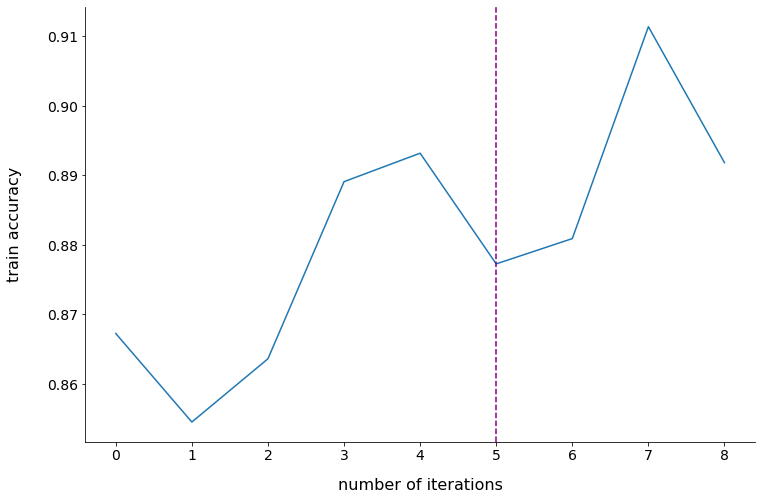

In [36]:
%matplotlib inline


fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)

plt.xlabel('number of iterations', labelpad=15)
plt.ylabel('train accuracy', labelpad=25)

earliest_stopping_response = np.amin([i for i, _ in enumerate(stopping_history) if stopping_history[i] is True])
plt.axvline(x=earliest_stopping_response, ymin=0, ymax=1, color='purple', ls='--')

sns.despine()

In [39]:
# Fit the model. We can get all the information using help(clf)
clf.fit(train)

In [44]:
def returnPrediction(df):
  #Step1 : Tokenize the data
  dummy_label = [2]*len(df) # Some dummy value here as we need to pass this value for tokenization
  tokenized_text = get_transformers_dataset(tokenizer, df, dummy_label)
  y_pred_unlabel,y_pred_proba = clf.predict(tokenized_text,return_proba=True)[0],clf.predict(tokenized_text,return_proba=True)[1]
  return y_pred_unlabel,y_pred_proba

#### Evaluate the model

In [45]:
y_pred_test, y_pred_test_proba = returnPrediction(test_cleantext)

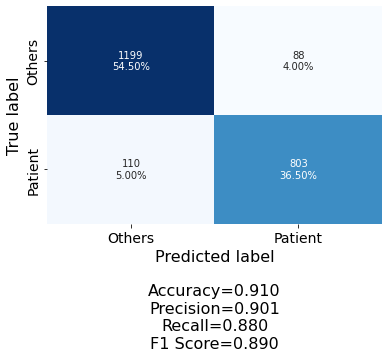

In [46]:
categories = ['Others', 'Patient']
cm = confusion_matrix(y_pred_test,test_label)
make_confusion_matrix(cm, cbar=False,
                      #group_names=labels,
                      categories=categories, 
                      cmap='Blues')

### Generate Labels 
Generate Labels for unlabeled dataset based on AL model.

In [47]:
#Generate Labels for the Unlabelled Dataset
#The probability will help to pick and mually annotate the models that the system is not sure of

nolabel_cleantext = df_unlabeled.to_list()
y_pred_test, y_pred_test_proba = returnPrediction(nolabel_cleantext)

In [56]:
probLabel1 = []
probLabel2 = []
for pred in y_pred_test_proba:
  probLabel1.append(pred[0])
  probLabel2.append(pred[1])

In [60]:
df_labeled = pd.DataFrame()
df_labeled['CleanText'] = nolabel_cleantext
df_labeled['Label'] = y_pred_test  #0 is for other, 1 for Patient
df_labeled['PredProb1'] = probLabel1
df_labeled['PredProb2'] = probLabel2
print(len(df_labeled))
print("Any Nulls?", df_labeled.isna().sum())


60123
Any Nulls? CleanText    0
Label        0
PredProb1    0
PredProb2    0
dtype: int64


In [61]:
df_labeled.sample(5)

,CleanText,Label,PredProb1,PredProb2
12792,Effect of Ocrelizumab in Blood Leukocytes of Patients With Primary Progressive MS Neurology MultipleSclerosis,0,0.998004,0.001996
56513,even if they get their way w FWP what do Tecfidera s look like in a world where ozanimod hits the mkt at k,0,0.996893,0.003107
25967,Im on Ocrevus and am having great success with it. Good luck.,1,0.005662,0.994337
45393,So important to hear something positive SARSCoV Lemtrada,0,0.995233,0.004767
3475,A look at why NICE didn t approve MS drug Ocrevus.,0,0.977985,0.022015


In [ ]:
df_labeled.to_csv("PredictedLabels_WithAL.csv")